## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [14]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [15]:
import pandas as pd
import os
import re
import numpy as np
import lightgbm as lgb
import shap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text, geom_line
from matplotlib import pyplot as plt

In [16]:
# number of trees in lightgbm
N_TREES = 40
N_ESTIMATORS = 300
MINIMUN_NUMBER_OF_TICKERS = 1500
# Number of the quarters in the past to train
N_TRAIN_QUARTES = 36
# number of tickers to make the portfolio
TOP_N = 10

In [17]:
data_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(''))), 'data', 'financials_against_return.feather')
raw_data_set = pd.read_feather(data_path)

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [18]:
df_quarter_lengths = raw_data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(raw_data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=MINIMUN_NUMBER_OF_TICKERS]

Create the target:

In [19]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

In [20]:
data_set.shape

(170483, 146)

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [21]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(TOP_N)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True


# My metrics
def pr_auc_metric(preds, train_data):
    labels = train_data.get_label()
    auc = average_precision_score(labels, preds)
    return "auc-pr", auc, True

def roc_auc_metric(preds, train_data):
    labels = train_data.get_label()
    auc = roc_auc_score(labels, preds)
    return "auc-roc", auc, True

def precision_top_n(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    labels = top_dataset["target"]
    precision = np.sum(labels)/len(labels)
    return "precision-top-n", precision, True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [22]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if N_TRAIN_QUARTES!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-N_TRAIN_QUARTES:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [23]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train set and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [24]:
import warnings
warnings.filterwarnings('ignore')


def train_model(
        train_set, test_set, n_estimators=N_ESTIMATORS, model_params=None, pca_pipelines=None
    ):
    columns_to_remove = get_columns_to_remove()

    if pca_pipelines: 
        X_train = add_pcs(train_set, pca_pipelines, fit=True).drop(columns=columns_to_remove, errors="ignore")
        X_test = add_pcs(test_set, pca_pipelines, fit=False).drop(columns=columns_to_remove, errors="ignore")
    else:
        X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
        X_test = test_set.drop(columns=columns_to_remove, errors="ignore")

    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

    eval_result = {}

    objective = 'binary'
    metric = 'binary_logloss'

    if model_params is not None:
        params = model_params
    else:
        params = {
            "random_state": 1,
            "verbosity": -1,
            "n_jobs": 10,
            "n_estimators": n_estimators,
            "objective": objective,
            "metric": metric
        }

    callbacks = [lgb.record_evaluation(eval_result=eval_result)]
    if "early_stopping_rounds" in params:
        callbacks.append(lgb.early_stopping(params["early_stopping_rounds"]))
    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        feval=[top_wt_performance, pr_auc_metric, roc_auc_metric, precision_top_n],
        callbacks=callbacks
    )
    return model, eval_result, X_train, X_test


 
            

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [25]:
def run_model_for_execution_date(
            execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,
            include_nulls_in_test = False, model_params=None, pca_pipelines = None
        ):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators,
                                                              model_params=model_params, pca_pipelines=pca_pipelines)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test


execution_dates = np.sort( data_set['execution_date'].unique() )


This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [26]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    (
        all_results,all_predicted_tickers_list,all_models,model,X_train,X_test
    ) = run_model_for_execution_date(
            execution_date,all_results,all_predicted_tickers_list,all_models,N_TREES,False
        )
    
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [27]:
def parse_results_into_df(set_, results=all_results):
    df = pd.DataFrame()
    for date in results:
        df_tmp = pd.DataFrame(results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [28]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [29]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

And this are the results:

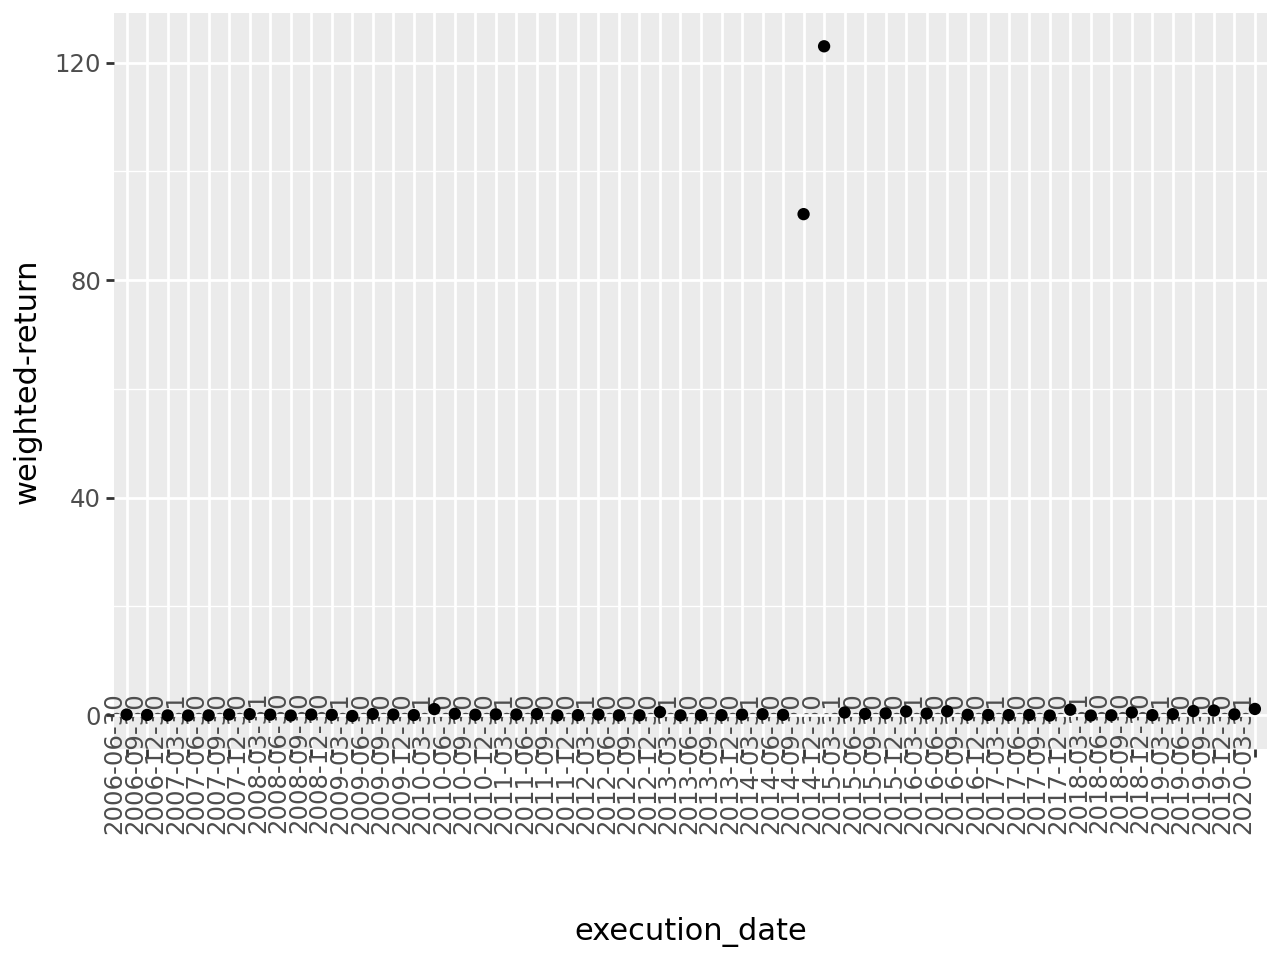

In [30]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

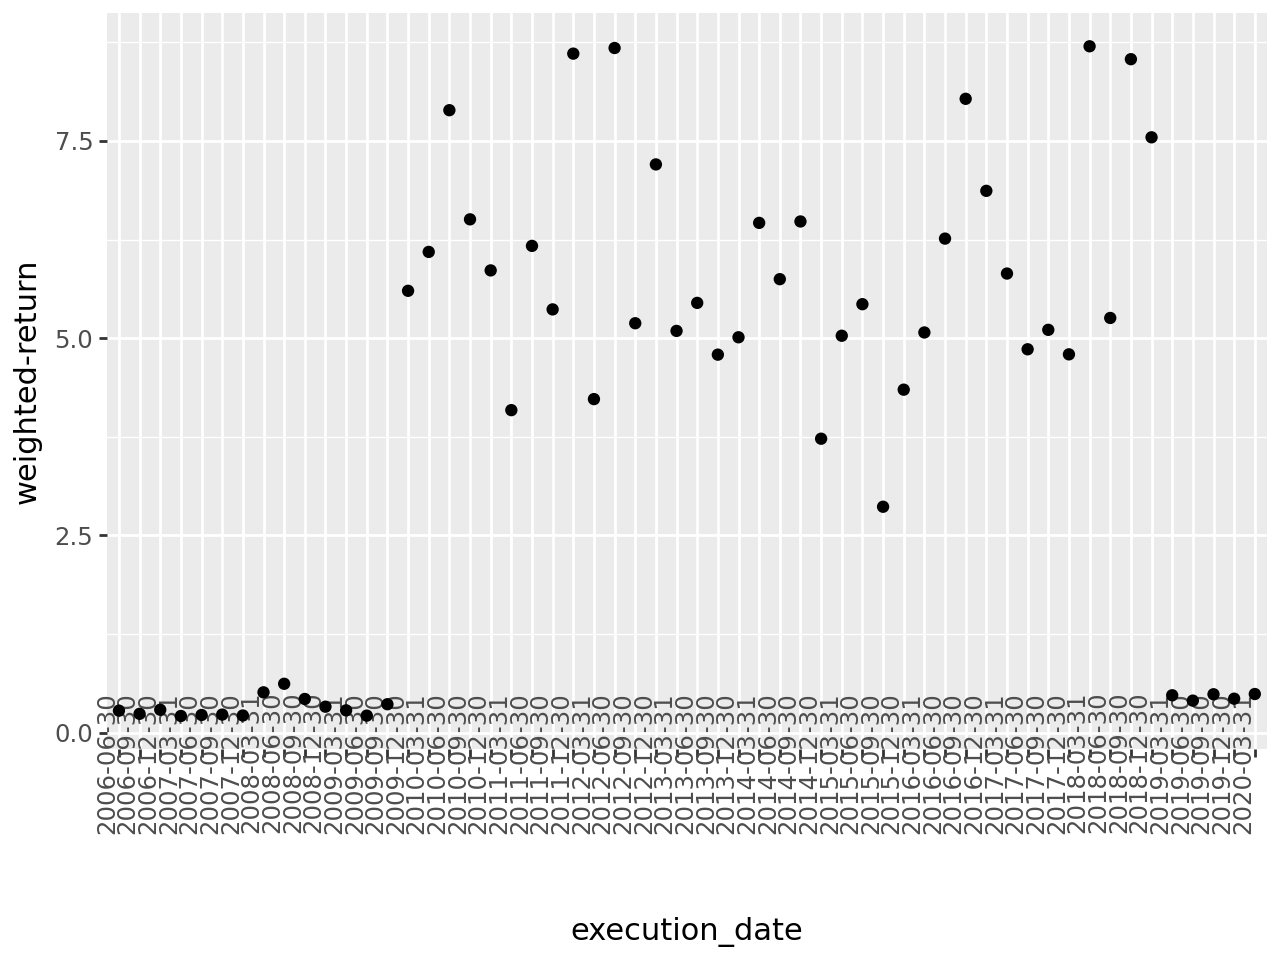

In [31]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [32]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot


---

## My Exploration

First of all, I'll plot the most important features among all models. So I'll create a function to acumulate all feature importances.

This will be a first aproximation, we must be careful and not rely too much on  the feature_importance of the trees

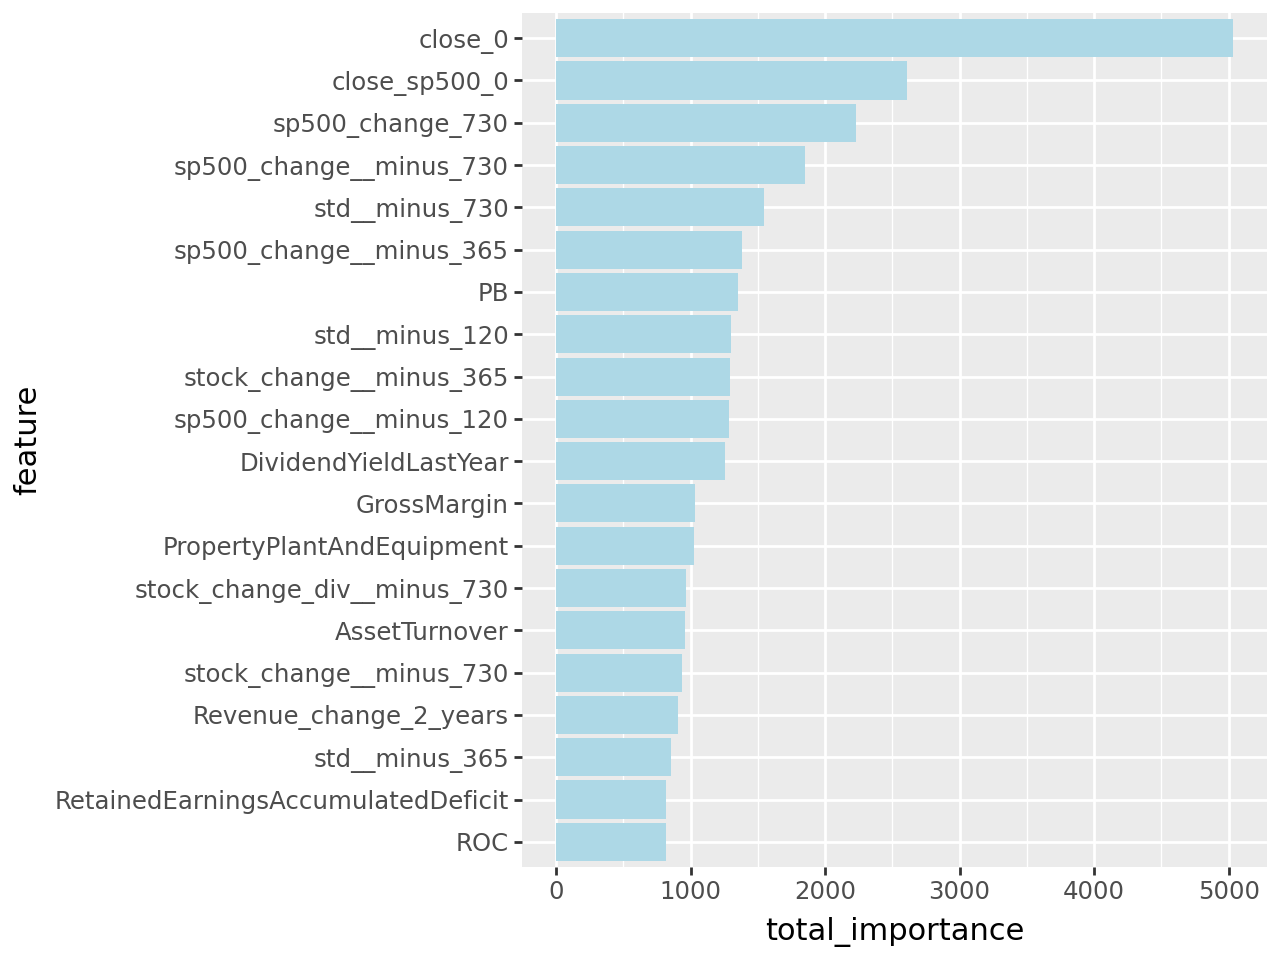

In [49]:
def get_top_n_features_across_models(n: int = 15, models=all_models) -> list:
    feature_importance_total = {}
    for model in models.values():
        fi = model.feature_importance()
        fn = model.feature_name()
        for i in range(len(fn)):
            feature_importance_total[fn[i]] = feature_importance_total.get(fn[i], 0) + fi[i]
    if not feature_importance_total:
        print("No feature importances found. Are the models trained?")
        return []
    fi_df = pd.DataFrame([
        {"feature": k, "total_importance": v}
        for k, v in feature_importance_total.items()
    ])
    fi_df = fi_df.sort_values("total_importance", ascending=False).head(n)
    return fi_df.sort_values("total_importance", ascending=True)

# Plot the top n features across all models
fi_df = get_top_n_features_across_models(20, all_models)
plot = ggplot(fi_df, aes(x="feature", y="total_importance")) + geom_col(fill="lightblue") + coord_flip() + scale_x_discrete(limits=fi_df["feature"])
plot.show()

Wait, `sp500_change_730` is a future feature, we shouldn't train the model with that feature. We have to remove it!

In [51]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_730", # Added, was making data leak
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

### About the Custom Metric

I believe that the business metric, as currently implemented, does not make logical sense when applied to the training set, because:

- It takes predictions for a specific `execution_date`
- Sorts tickers by predicted probability
- Selects the TOP_N tickers
- Calculates the average return of that "portfolio"

When evaluating on the training set:
- We have data from multiple `execution_date`s (36 historical quarters)
- The model predicts on all these quarters mixed together
- Then it selects the TOP_N tickers with the highest probability, regardless of the quarter
- This does not simulate a real investment decision

To properly compare predictions on train and test, it would be better to look at other metrics such as:
- LogLoss
- ROC-AUC
- PR-AUC

The business metric only makes sense when evaluating tickers for a specific `execution_date`. 

I also have added a metric very similar to the given one: 
- Precision on Top N

Here I define functions to plot training curves

In [70]:
def plot_concatenated_training_curves(
    all_results,
    metrics=["binary_logloss", "auc-pr", "auc-roc"],
    set_names=["training", "valid_0"],
    figsize=(20, 16),
    add_separators=True
):

    execution_dates = sorted(all_results.keys())
    
    color_map = {
        "binary_logloss": "#2c78ad",
        "auc-pr": "#b5d13a", 
        "auc-roc": "#e07b91",
        "precision-top-n": "#615340",
        "weighted-return": "#3f3f3f"
    }
    
    alpha_map = {
        "training": 0.6,  
        "valid_0": 1.0    
    }
    
    style_map = {
        "training": "-",   
        "valid_0": "-"     
    }
    
    n_metrics = len(metrics)
    # Creamos los subplots SIN compartir el eje X para el último
    fig, axes = plt.subplots(n_metrics + 1, 1, figsize=figsize, sharex=False)
    if n_metrics == 1:
        axes = [axes]
    
    # Compartimos el eje X solo entre los primeros n_metrics gráficos
    if n_metrics > 1:
        for i in range(1, n_metrics):
            axes[i].sharex(axes[0])
    
    separator_positions = []
    current_x = 0
    
    for date_idx, date in enumerate(execution_dates):
        if date in all_results:
            n_trees = 0
            for set_name in set_names:
                if (set_name in all_results[date] and 
                    len(metrics) > 0 and 
                    metrics[0] in all_results[date][set_name]):
                    n_trees = len(all_results[date][set_name][metrics[0]])
                    break
            
            if n_trees > 0 and date_idx < len(execution_dates) - 1:
                separator_positions.append(current_x + n_trees)
                current_x += n_trees

    for metric_idx, metric in enumerate(metrics):
        ax = axes[metric_idx]
        
        for set_name in set_names:
            if set_name == 'training' and metric in ['weighted-return', 'precision-top-n']:
                print(f"Skipping {set_name} for metric {metric} as it is not applicable.")
                continue
            x_concat = []
            y_concat = []
            current_x = 0
            
            for date in execution_dates:
                if (date in all_results and 
                    set_name in all_results[date] and 
                    metric in all_results[date][set_name]):
                    
                    values = all_results[date][set_name][metric]
                    n_trees = len(values)
                    
                    x_values = list(range(current_x, current_x + n_trees))
                    x_concat.extend(x_values)
                    y_concat.extend(values)
                    
                    current_x += n_trees
            
            if x_concat and y_concat:
                label = "Train" if set_name == "training" else "Validation"
                ax.plot(x_concat, y_concat,
                       color=color_map.get(metric, 'black'),
                       alpha=alpha_map.get(set_name, 0.8),
                       linestyle=style_map.get(set_name, '-'),
                       linewidth=1.5,
                       label=label)
        
        # Add red line at y=0 for weighted-return
        if metric == "weighted-return":
            ax.axhline(y=0.0, color='red', linestyle='-', linewidth=1.2, alpha=0.7, label='SP500 return')
        
        if add_separators:
            for sep_pos in separator_positions:
                ax.axvline(x=sep_pos, color='gray', linestyle='--', alpha=0.3, linewidth=1)
        
        ax.set_ylabel(metric.replace("_", " ").replace("-", " ").title(), fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_title(f'{metric.replace("_", " ").replace("-", " ").title()} - Training vs Validation', 
                    fontsize=12, pad=10)
        
        # --- Set y-axis limits for metrics in [0, 1] ---
        if metric in ["binary_logloss", "auc-pr", "auc-roc"]:
            ax.set_ylim(0, 1)
        # --- Limit weighted-return y-axis to 6 ---
        if metric == "weighted-return":
            ax.set_ylim(-1, 6)
        
        if len(set_names) > 1 or (metric == "weighted-return"):
            ax.legend(loc='upper right', fontsize=10)
    
    # ========== PARTE CORREGIDA: ACUMULATIVO SOLO CON VALORES FINALES ==========
    ax_cum = axes[-1]
    
    # Solo procesamos validation (valid_0)
    final_returns = []
    final_dates = []
    
    for date in execution_dates:
        if (date in all_results and 
            'valid_0' in all_results[date] and 
            "weighted-return" in all_results[date]['valid_0']):
            
            # Tomamos SOLO el valor final (último árbol) de cada fecha
            final_return = all_results[date]['valid_0']["weighted-return"][-1]
            final_returns.append(final_return)
            final_dates.append(date)
    
    # Calculamos el acumulativo sobre los valores finales
    if final_returns:
        cumulative_returns = np.cumsum(final_returns)
        x_positions = range(len(final_returns))
        
        ax_cum.plot(x_positions, cumulative_returns, 
                   color=color_map["weighted-return"], 
                   alpha=1.0, 
                   linewidth=2,
                   label="Validation Cumulative (Final Values)")
        
        # Añadimos separadores verticales en las posiciones de las fechas
        if add_separators and len(final_returns) > 1:
            for i in range(1, len(final_returns)):
                ax_cum.axvline(x=i-0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    ax_cum.axhline(y=0.0, color='red', linestyle='-', linewidth=1.2, alpha=0.7)
    ax_cum.set_ylabel("Cumulative Weighted Return", fontsize=11)
    ax_cum.set_title("Cumulative Weighted Return - Validation (Final Values Only)", fontsize=12, pad=10)
    ax_cum.grid(True, alpha=0.3)
    ax_cum.legend(loc='upper right', fontsize=10)
    
    # Configuramos las etiquetas del eje X para mostrar las fechas
    if len(final_dates) <= 30:
        ax_cum.set_xticks(range(len(final_dates)))
        date_labels = [str(date)[:7] for date in final_dates]
        ax_cum.set_xticklabels(date_labels, rotation=45, fontsize=8)
        ax_cum.set_xlabel('Execution Date', fontsize=12)
    else:
        ax_cum.set_xlabel('Execution Date Index', fontsize=12)
    
    # ========== FIN PARTE CORREGIDA ==========
    
    # Configuramos las etiquetas del eje X solo para los gráficos de métricas (no para el acumulativo)
    if len(execution_dates) <= 30:
        x_labels_pos = []
        current_x = 0
        
        for date in execution_dates:
            if date in all_results:
                n_trees = 0
                for set_name in set_names:
                    if (set_name in all_results[date] and 
                        len(metrics) > 0 and 
                        metrics[0] in all_results[date][set_name]):
                        n_trees = len(all_results[date][set_name][metrics[0]])
                        break
                
                if n_trees > 0:
                    x_labels_pos.append(current_x + n_trees // 2)
                    current_x += n_trees
        
        date_labels = [str(date)[:7] for date in execution_dates]
        
        if x_labels_pos and len(date_labels) == len(x_labels_pos):
            ax2 = axes[0].twiny()
            ax2.set_xlim(axes[0].get_xlim())
            ax2.set_xticks(x_labels_pos)
            ax2.set_xticklabels(date_labels, rotation=45, fontsize=8)
            ax2.set_xlabel('Execution Date', fontsize=10)
    
    # Añadimos etiqueta X solo al penúltimo gráfico (último de las métricas)
    axes[n_metrics-1].set_xlabel('Concatenated Tree Index (across all execution dates)', fontsize=12)
    
    plt.suptitle('Training vs Validation Curves (with Cumulative Weighted Return)', 
                fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

Skipping training for metric precision-top-n as it is not applicable.
Skipping training for metric weighted-return as it is not applicable.


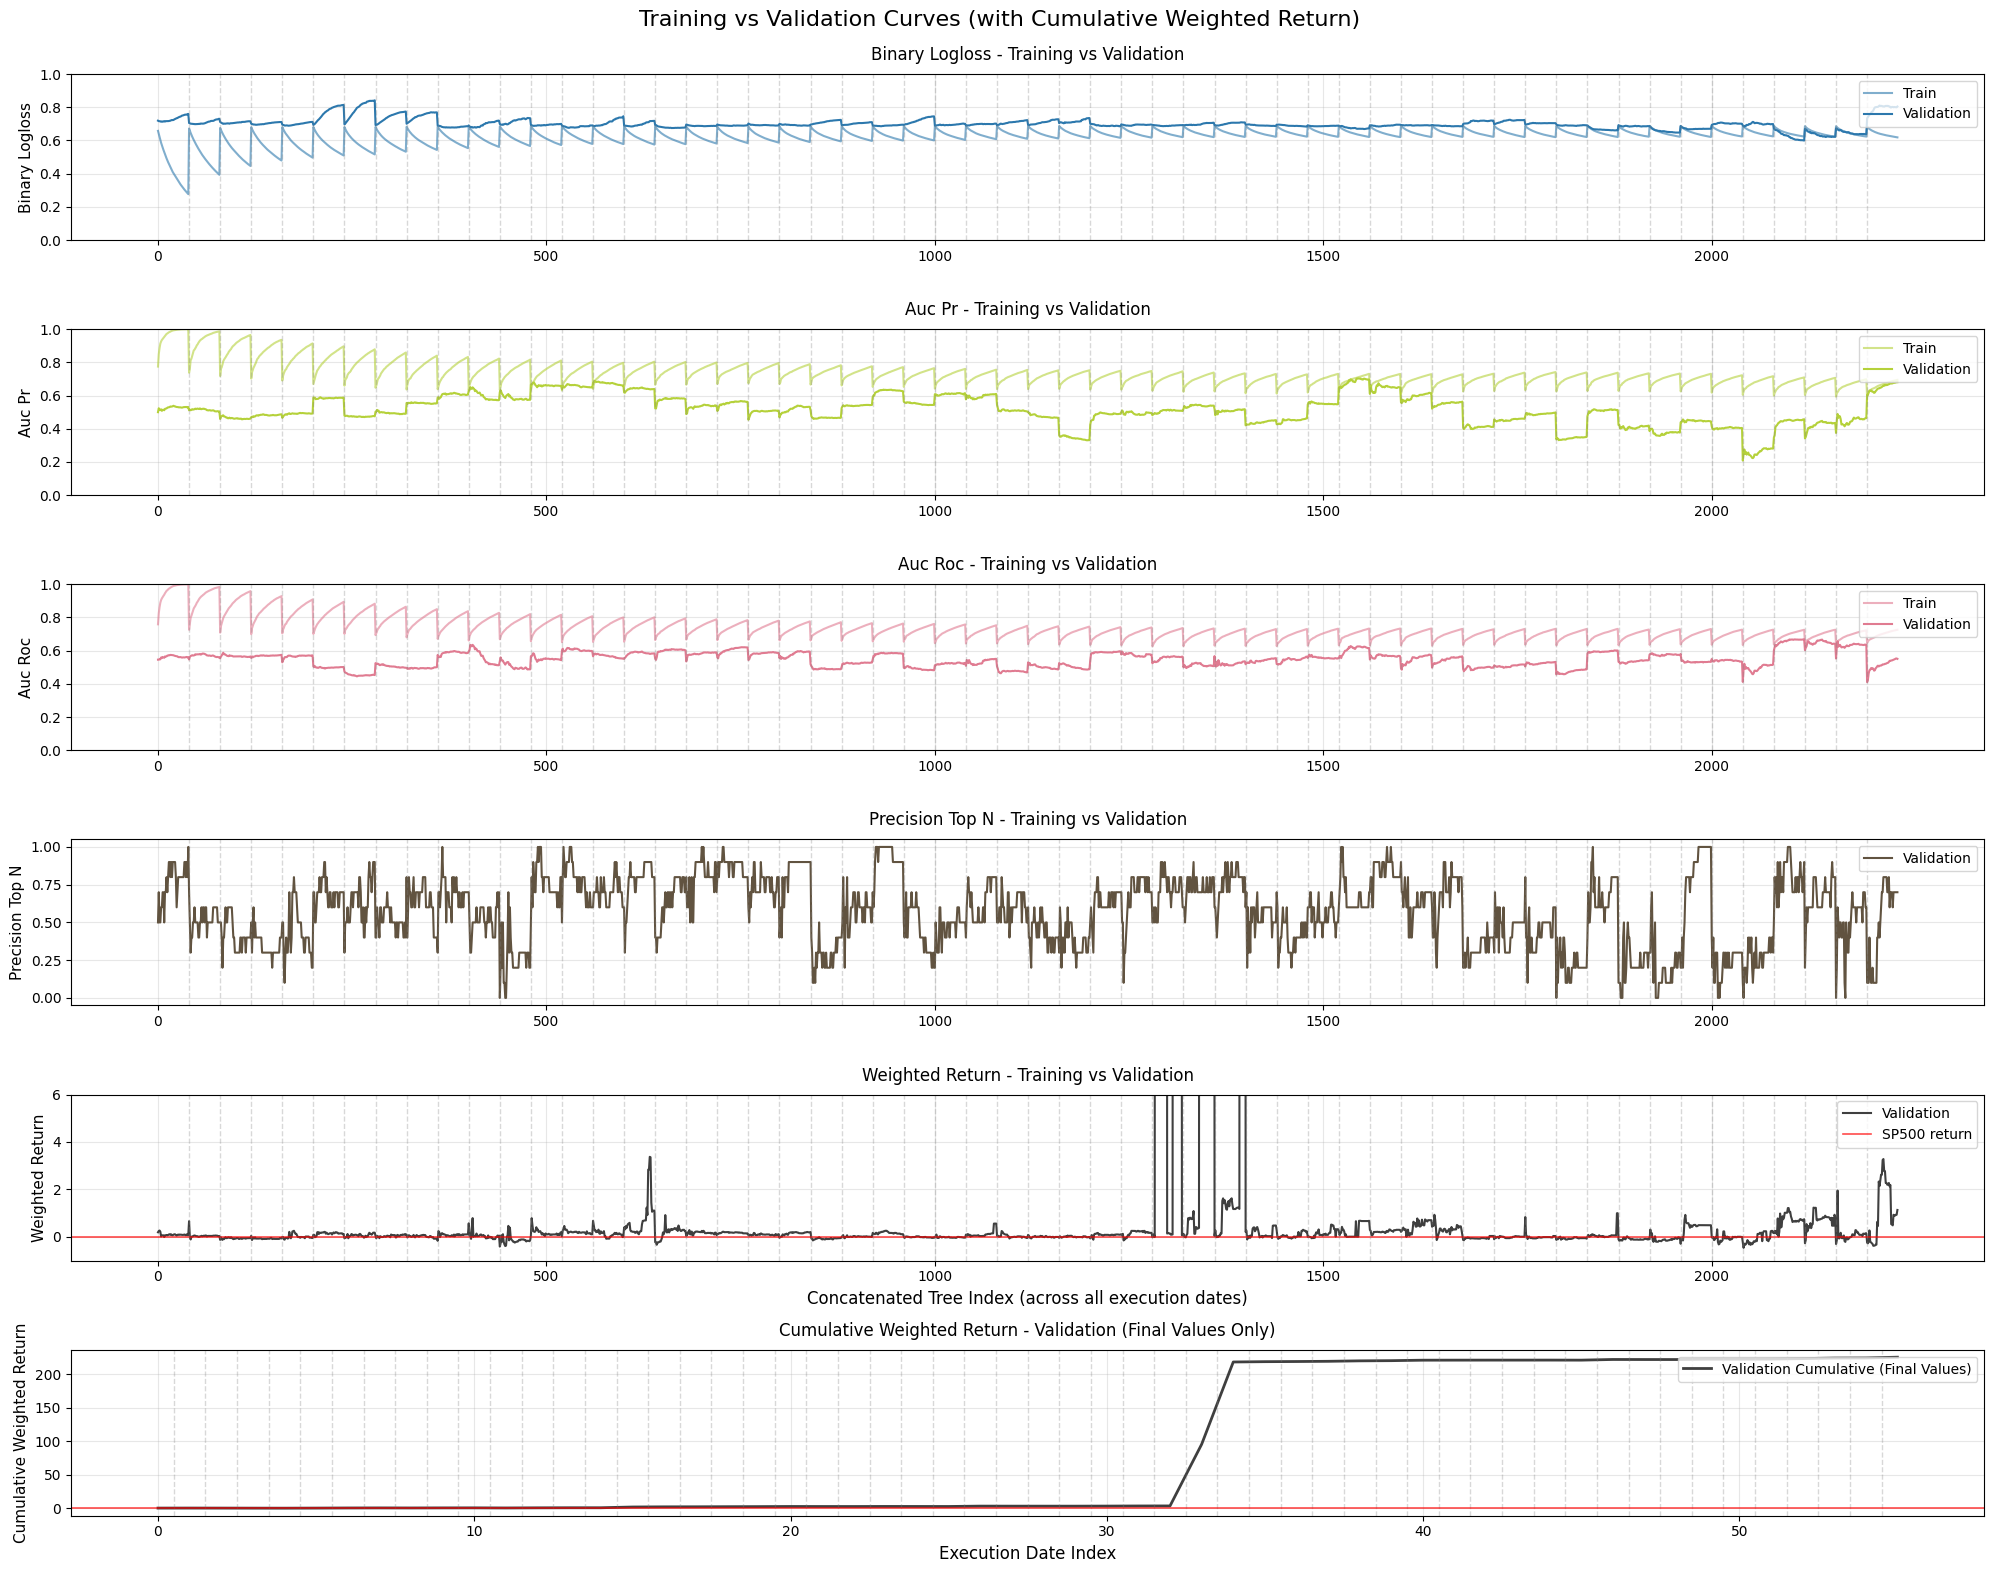

In [71]:
plot_concatenated_training_curves(
    all_results,
    metrics=["binary_logloss", "auc-pr", "auc-roc", "precision-top-n", "weighted-return"],
)

## Training Curves Analysis - Key Findings

### Model Behavior Patterns

**Training Performance**: Models successfully minimize log-loss and increase AUC scores during training. However, **early execution dates show perfect training fit**, while **later models struggle to fit training data as well**. Could be because a large ``N_TRAIN_QUARTERS``

**Validation Concerns**: Clear signs of **overfitting detected**:
- Log-loss increases on validation (should decrease like training)
- AUC curves show inconsistent patterns on validation
- Models fail to generalize beyond training data

### Custom Metrics Analysis

**Precision Top-N on Training**: Always reaches 100% by final iterations - **not meaningful** since it selects best tickers across ``N_TRAIN_QUARTERS`` quarters rather than within single execution date.

**Weighted Return**: 
- Training results are **not significant** for same reason as precision
- Validation shows **random patterns** with no clear learning signal
- Extreme spikes likely due to small-cap stocks with large percentage changes



I'll try adjusting Hiperparameters to reduce overfitting:
1. Lower learning rate: `0.01`
2. Define a `max_depth`
3. Subsampling
4. Lower `N_TRAIN_QUARTERS`

And also define `early_stopping_rounds`, to stop learning if we aren't improving the metrics

In [58]:
N_TRAIN_QUARTES = 16  # 4 years back
MAX_DEPTH = 6
N_TREES = 60    # Higher, but with early stopping
LEARNING_RATE = 0.01
FEATURE_FRACTION = 0.7
BAGGING_FRACTION = 0.8
EARLY_STOPPING_ROUNDS = 10

model_params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": "binary",
    "metric": "binary_logloss",
    "n_estimators": N_TREES,
    "max_depth": MAX_DEPTH,
    "learning_rate": LEARNING_RATE,
    'feature_fraction': FEATURE_FRACTION,
    'bagging_fraction': BAGGING_FRACTION,
    "early_stopping_rounds": EARLY_STOPPING_ROUNDS
}


my_all_results = {}
my_all_predicted_tickers_list = []
my_all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    (
        my_all_results, my_all_predicted_tickers_list, my_all_models, model, X_train, X_test
    ) = run_model_for_execution_date(
            execution_date, my_all_results, my_all_predicted_tickers_list, my_all_models, N_TREES, False, model_params
        )
    
my_all_predicted_tickers = pd.concat(my_all_predicted_tickers_list)

my_test_results = parse_results_into_df("valid_0", my_all_results)
my_train_results = parse_results_into_df("training", my_all_results)

my_test_results_final_tree = my_test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
my_train_results_final_tree = my_train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
Training until validation scores don't improve for 10 rounds
2006-09-30T00:00:00.000000000
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685311	training's weighted-return: 0.285193	training's auc-pr: 0.73562	training's auc-roc: 0.716213	training's precision-top-n: 0.9	valid_0's binary_logloss: 0.707365	valid_0's weighted-return: 0.623357	valid_0's auc-pr: 0.500587	valid_0's auc-roc: 0.541238	valid_0's precision-top-n: 0.9
2006-12-30T00:00:00.000000000
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.685774	training's weighted-return: 0.632837	training's auc-pr: 0.730516	training's auc-roc: 0.717158	training's precision-top-n: 1	valid_0's binary_logloss: 0.71379	valid_0's weighte

Skipping training for metric precision-top-n as it is not applicable.
Skipping training for metric weighted-return as it is not applicable.


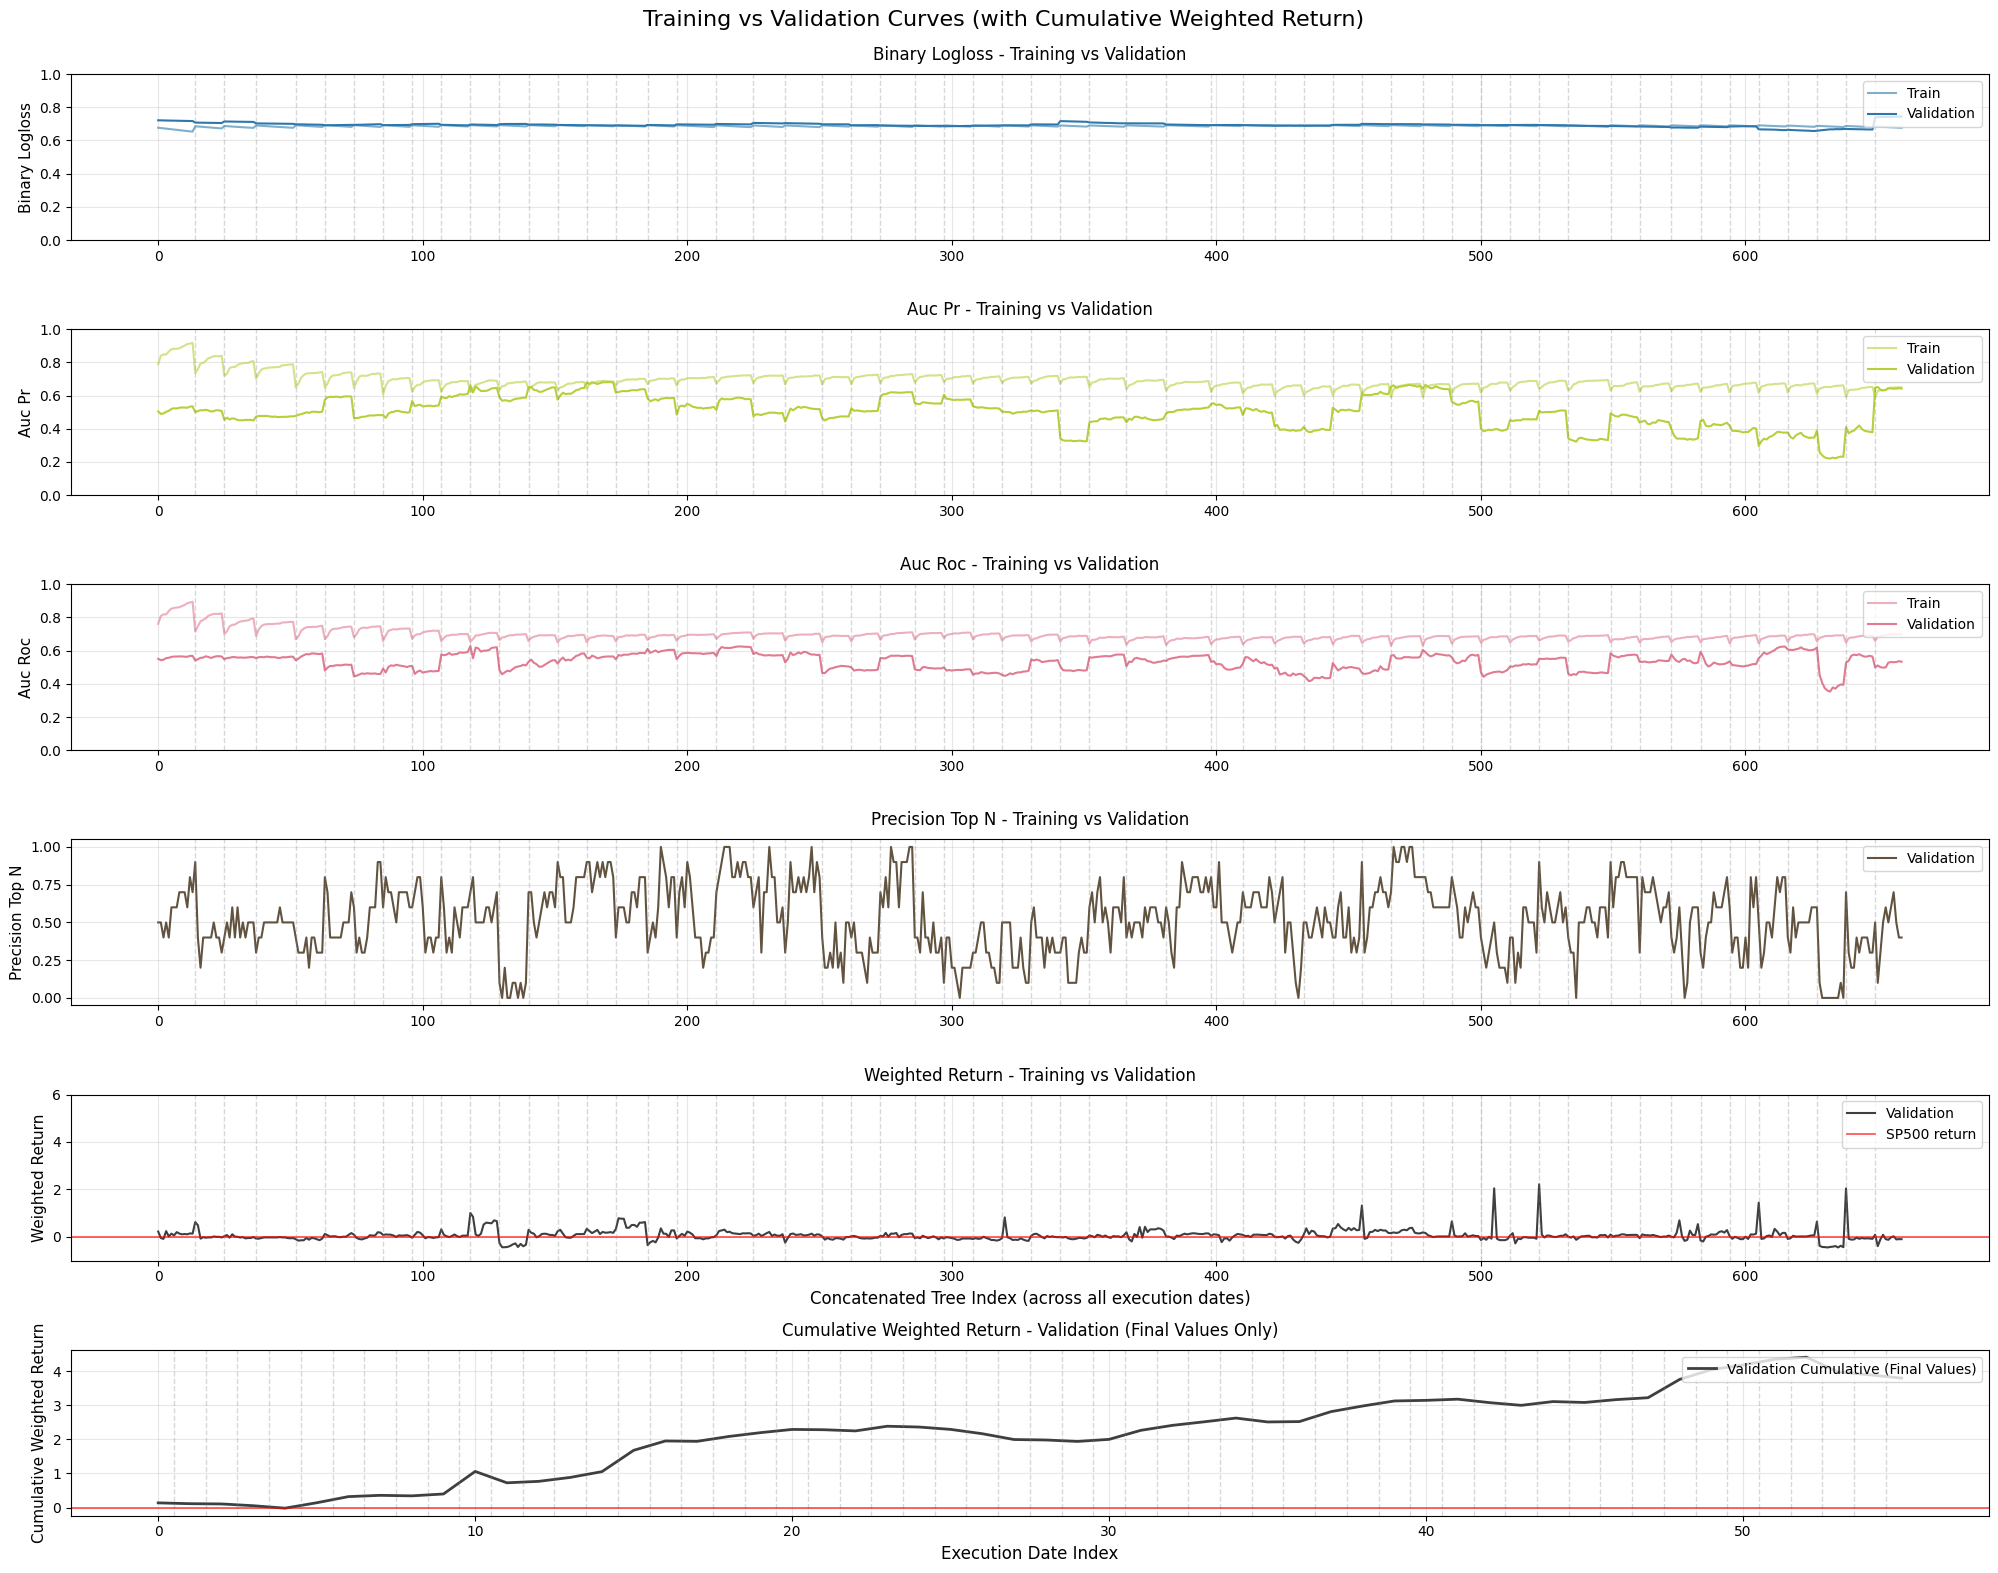

In [72]:
plot_concatenated_training_curves(
    my_all_results,
    metrics=["binary_logloss", "auc-pr", "auc-roc", "precision-top-n", "weighted-return"],
)

We have improved a lot, now we can see that models seem to be improving.

- Same logloss in train and validation in almost all models. We have made trade-off between bias and variance. Now less variance but more bias. 

### **How to know if the model is working well?**

To properly assess whether our LightGBM model is adding real value, we need to compare it against simple baseline strategies.

1. **Market Cap Strategy**: Select the TOP_N tickers with the highest market capitalization at each execution date

2. **Random Strategy**: Randomly select TOP_N tickers at each execution date

3. **Momentum Strategy**: Select TOP_N tickers with the highest recent price performance

Procesing 1/64: 2005-06-30T00:00:00.000000000
Procesing 11/64: 2007-12-30T00:00:00.000000000
Procesing 21/64: 2010-06-30T00:00:00.000000000
Procesing 31/64: 2012-12-30T00:00:00.000000000
Procesing 41/64: 2015-06-30T00:00:00.000000000
Procesing 51/64: 2017-12-30T00:00:00.000000000
Procesing 61/64: 2020-06-30T00:00:00.000000000
⚠️  Only 0 tickers available for execution date 2020-06-30T00:00:00.000000000. Need at least 10.
⚠️  Only 0 tickers available for execution date 2020-09-30T00:00:00.000000000. Need at least 10.
⚠️  Only 0 tickers available for execution date 2020-12-30T00:00:00.000000000. Need at least 10.
⚠️  Only 0 tickers available for execution date 2021-03-27T00:00:00.000000000. Need at least 10.


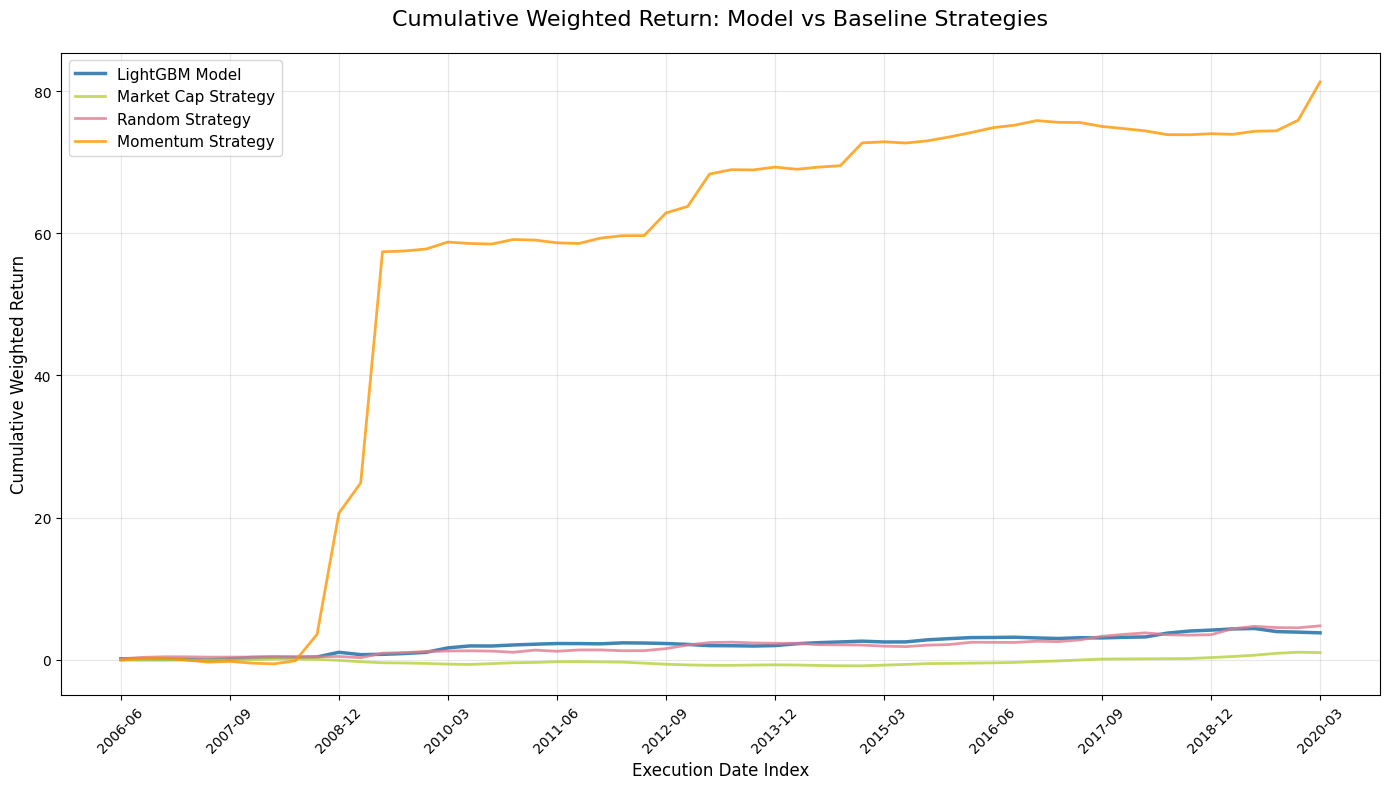


CUMULATIVE PERFORMANCE SUMMARY
LightGBM Model:         3.79
Market Cap:             1.01
Random:                 4.78
Momentum:              81.29


In [73]:
def market_cap_strategy(test_set, top_n=10):
    market_cap_col = 'Market_cap'
    return test_set.nlargest(top_n, market_cap_col)

def random_strategy(test_set, top_n=10, random_state=None):
    if random_state is None:
        raise ValueError("random_state must be provided for reproducibility")
    
    selected = test_set.sample(min(top_n, len(test_set)), random_state=random_state)
    return selected

def momentum_strategy(test_set, top_n=10):
    momentum_col = 'stock_change__minus_120'
    return test_set.nlargest(top_n, momentum_col)

def run_benchmark_strategies(execution_date, top_n=10):
    _, test_set = split_train_test_by_period(data_set, execution_date)
    
    if len(test_set) < top_n:
        print(f"⚠️  Only {len(test_set)} tickers available for execution date {execution_date}. Need at least {top_n}.")
        return None
    
    results = {
        'execution_date': execution_date,
        'total_tickers': len(test_set)
    }
    
    try:
        market_cap_selection = market_cap_strategy(test_set, top_n)
        market_cap_return = market_cap_selection['diff_ch_sp500'].mean()
        results['market_cap_return'] = market_cap_return
        results['market_cap_tickers'] = list(market_cap_selection['Ticker'].values)
    except Exception as e:
        print(f"Error Market Cap strategy: {e}")
        results['market_cap_return'] = np.nan
        results['market_cap_tickers'] = []
    
    try:
        random_selection = random_strategy(test_set, top_n, random_state=1)
        random_return = random_selection['diff_ch_sp500'].mean()
        results['random_return'] = random_return
        results['random_tickers'] = list(random_selection['Ticker'].values)
    except Exception as e:
        print(f"Error Random strategy: {e}")
        results['random_return'] = np.nan
        results['random_tickers'] = []
    
    try:
        momentum_selection = momentum_strategy(test_set, top_n)
        momentum_return = momentum_selection['diff_ch_sp500'].mean()
        results['momentum_return'] = momentum_return
        results['momentum_tickers'] = list(momentum_selection['Ticker'].values)
    except Exception as e:
        print(f"Error Momentum strategy: {e}")
        results['momentum_return'] = np.nan
        results['momentum_tickers'] = []
    
    return results

def run_all_benchmarks():
    benchmark_results = []
    
    for i, execution_date in enumerate(execution_dates):
        if i % 10 == 0:  # Progress indicator
            print(f"Procesing {i+1}/{len(execution_dates)}: {execution_date}")
        
        result = run_benchmark_strategies(execution_date, top_n=TOP_N)
        if result is not None:
            benchmark_results.append(result)
    
    benchmark_df = pd.DataFrame(benchmark_results)
    return benchmark_df

def plot_cumulative_comparison_with_baselines(my_all_results, execution_dates):
    
    model_returns = []
    model_dates = []
    
    for date in execution_dates:
        if (date in my_all_results and 
            'valid_0' in my_all_results[date] and 
            'weighted-return' in my_all_results[date]['valid_0']):
            
            final_return = my_all_results[date]['valid_0']['weighted-return'][-1]
            model_returns.append(final_return)
            model_dates.append(date)
    
    benchmark_df = run_all_benchmarks()
    
    model_df = pd.DataFrame({
        'execution_date': model_dates,
        'model_return': model_returns
    })
    
    model_df['execution_date'] = model_df['execution_date'].astype(str)
    benchmark_df['execution_date'] = benchmark_df['execution_date'].astype(str)
    
    comparison_df = pd.merge(model_df, benchmark_df, on='execution_date', how='inner')
    
    comparison_df = comparison_df.sort_values('execution_date')
    
    model_cumulative = comparison_df['model_return'].cumsum()
    market_cap_cumulative = comparison_df['market_cap_return'].cumsum()
    random_cumulative = comparison_df['random_return'].cumsum()
    momentum_cumulative = comparison_df['momentum_return'].cumsum()
    
    plt.figure(figsize=(14, 8))
    
    x_positions = range(len(comparison_df))
    
    plt.plot(x_positions, model_cumulative, 
             color='#2c78ad', linewidth=2.5, label='LightGBM Model', alpha=0.9)
    plt.plot(x_positions, market_cap_cumulative, 
             color='#b5d13a', linewidth=2, label='Market Cap Strategy', alpha=0.8)
    plt.plot(x_positions, random_cumulative, 
             color='#e07b91', linewidth=2, label='Random Strategy', alpha=0.8)
    plt.plot(x_positions, momentum_cumulative, 
             color='#ff9500', linewidth=2, label='Momentum Strategy', alpha=0.8)
    
    plt.title('Cumulative Weighted Return: Model vs Baseline Strategies', fontsize=16, pad=20)
    plt.xlabel('Execution Date Index', fontsize=12)
    plt.ylabel('Cumulative Weighted Return', fontsize=12)
    plt.legend(loc='upper left', fontsize=11)
    plt.grid(True, alpha=0.3)
    
    n_labels = min(10, len(comparison_df))
    step = len(comparison_df) // n_labels
    label_positions = range(0, len(comparison_df), step)
    label_dates = [comparison_df.iloc[i]['execution_date'][:7] for i in label_positions]
    
    plt.xticks(label_positions, label_dates, rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("CUMULATIVE PERFORMANCE SUMMARY")
    print("="*60)
    
    final_model = model_cumulative.iloc[-1]
    final_market_cap = market_cap_cumulative.iloc[-1]
    final_random = random_cumulative.iloc[-1]
    final_momentum = momentum_cumulative.iloc[-1]
    
    print(f"LightGBM Model:     {final_model:8.2f}")
    print(f"Market Cap:         {final_market_cap:8.2f}")
    print(f"Random:             {final_random:8.2f}")
    print(f"Momentum:           {final_momentum:8.2f}")
    
    return comparison_df

comparison_results = plot_cumulative_comparison_with_baselines(my_all_results, execution_dates)

Our system does not seem to outperform the random baseline, which is a very bad sign and means it is not adding value. Furthermore, the momentum system appears to work very well.

This can happen because Momentum Strategy, by chance, has choose a very good ticker only because its trend was optimistic. ¿But really means that momentum strategy is performing better? If we consider the cumulative performance, yes, but in production, when a really optimistic ticker appears, would mean that in 1 year will give good returns? We don't know

---------------------------------------------------------------------------------------------------

Lets explore correlations between features

In [74]:
def plot_corr(
    df: pd.DataFrame, columns: list[str], figsize: tuple = (8, 6)
    ) -> None:

    threshold = 15 

    if not all(col in df.columns for col in columns):
        missing = [col for col in columns if col not in df.columns]
        raise ValueError(f"Columns not found in dataframe: {missing}")

    corr = df[columns].corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))
    corr_masked = corr.mask(mask)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(corr_masked, vmin=-1, vmax=1, cmap="coolwarm")

    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    ax.set_xticklabels(columns, rotation=90)
    ax.set_yticklabels(columns)

    # Show correlation values if number of columns is below threshold
    if len(columns) <= threshold:
        for i in range(len(columns)):
            for j in range(len(columns)):
                if not mask[i, j]:
                    val = corr.iloc[i, j]
                    if not np.isnan(val):
                        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black", fontsize=9)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Pearson $r$", rotation=270, labelpad=15)

    ax.set_title("Correlation matrix (lower triangle)")
    plt.tight_layout()
    plt.show()

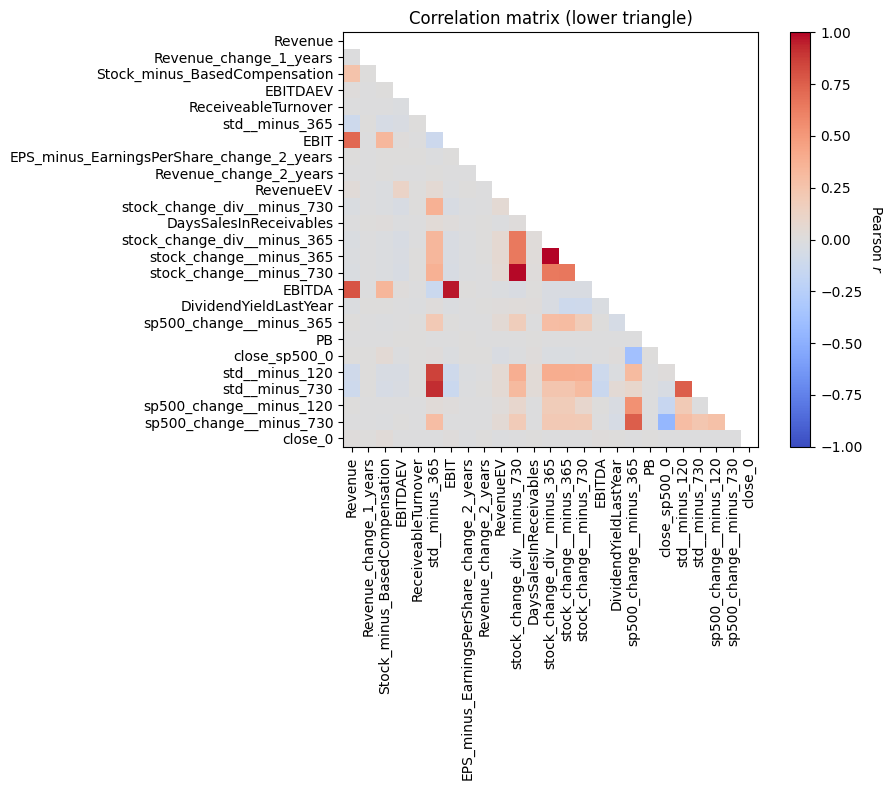

In [82]:
plot_corr(
    data_set,
    columns=get_top_n_features_across_models(25, my_all_models)['feature'].tolist(),
    figsize=(10, 8)
)

We can see highly correlated features groups:

* **SP500:** `sp500_change__minus_730`, `sp500_change__minus_365` and `sp500_change__minus_120`
* **Volatility:** `std__minus_730`, `std__minus_730` and `std__minus_120`
* **Stock Change:** `stock_change__minus_120` vs. `stock_change_div__minus_730`

In general, those features with the change in short time vs the change in long time

### PCA

I'll compress each block into 1–2 orthogonal “factors”.

- PC-1 of the three S&P-500 change variables
- PC-1 of the three std_* variables
- ...

In [85]:
sp500_cols = [
    "sp500_change__minus_730",
    "sp500_change__minus_365",
    "sp500_change__minus_120",
]

vol_cols = [
    "std__minus_730",
    "std__minus_365",
    "std__minus_120",
]

stock_change_cols = [
    "stock_change__minus_120",
    "stock_change__minus_365",
    "stock_change__minus_730",
    "stock_change_div__minus_120",
    "stock_change_div__minus_365",
    "stock_change_div__minus_730",
]

profitability_cols = [
    "EBITDA",
    'EBIT',
    'GrossProfit',
    'Revenue'
]


# build per-group PCA pipelines -----------------------------
pca_pipelines = {
    "sp500_trend_pc": Pipeline([
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=1))
    ]),
    "volatility_pc": Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=1))
    ]),
    "stock_change_trend_pc": Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=2))
    ]),
    "profitability_pc": Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=1))
    ]),
}

def add_pcs(df, pca_pipelines, fit=True) -> pd.DataFrame:
    df_new = df.copy()
    for name, pipe in pca_pipelines.items():
        if 'sp500' in name:
            cols = sp500_cols
        elif 'volatility' in name:
            cols = vol_cols
        elif 'stock_change' in name:
            cols = stock_change_cols
        elif 'profitability' in name:
            cols = profitability_cols
        else:
            raise ValueError(f"Unknown pipeline name: {name}")
        
        if fit:
            pipe.fit(df_new[cols])
        
        transformed = pipe.transform(df_new[cols])
        
        if transformed.shape[1] == 1:
            df_new[name] = transformed[:, 0]
        else:
            for i in range(transformed.shape[1]):
                df_new[f"{name}_{i+1}"] = transformed[:, i]
        
        df_new = df_new.drop(columns=cols)
    
    return df_new

Use pca in walk-forward loop:

In [86]:
all_results_pca = {}
all_predicted_tickers_list_pca = []
all_models_pca = {}

for execution_date in execution_dates:
    print(execution_date)
    (
        all_results_pca,all_predicted_tickers_list_pca,all_models_pca,model,
        X_train,X_test
    ) = run_model_for_execution_date(
        execution_date,all_results_pca,all_predicted_tickers_list_pca,
        all_models_pca,N_TREES,False, model_params, pca_pipelines=pca_pipelines)
    
all_predicted_tickers_pca = pd.concat(all_predicted_tickers_list_pca) 

pca_test_results = parse_results_into_df("valid_0", all_results_pca)
pca_train_results = parse_results_into_df("training", all_results_pca)

pca_test_results_final_tree = pca_test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
pca_train_results_final_tree = pca_train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
Training until validation scores don't improve for 10 rounds
2006-09-30T00:00:00.000000000
Training until validation scores don't improve for 10 rounds
2006-12-30T00:00:00.000000000
Training until validation scores don't improve for 10 rounds
2007-03-31T00:00:00.000000000
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.688947	training's weighted-return: 0.0450587	training's auc-pr: 0.696508	training's auc-roc: 0.69682	training's precision-top-n: 0.7	valid_0's binary_logloss: 0.702372	valid_0's weighted-return: 0.037305	valid_0's auc-pr: 0.463897	valid_0's auc-roc: 0.543354	valid_0's precision-top-n: 0.7
2007-06-30T00:00:00.000000000
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0

In [87]:
for name, pipe in pca_pipelines.items():
     for i, evr in enumerate(pipe.named_steps['pca'].explained_variance_ratio_):
          print(f"{name} {i+1}: {evr:.2%} of variance" )

sp500_trend_pc 1: 67.44% of variance
volatility_pc 1: 91.13% of variance
stock_change_trend_pc 1: 67.05% of variance
stock_change_trend_pc 2: 22.38% of variance
profitability_pc 1: 83.93% of variance


Now lets see which are these models most important features, and plot the correlation between them:

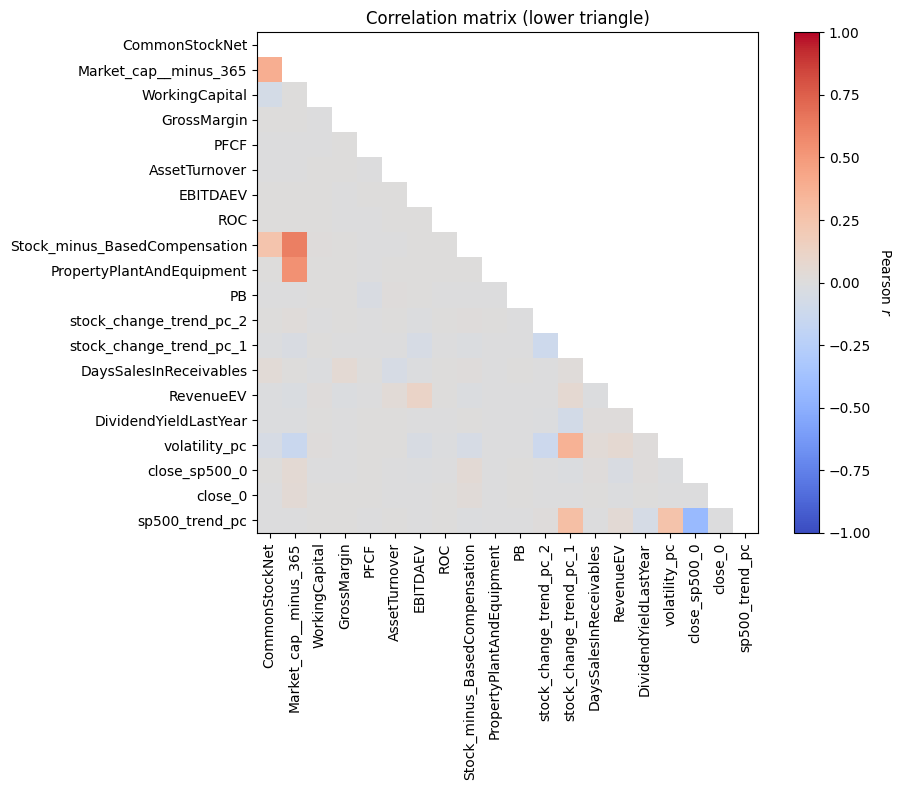

In [88]:
plot_corr(
    add_pcs(data_set, pca_pipelines, fit=False),
    columns=get_top_n_features_across_models(20, all_models_pca)['feature'].tolist(),
    figsize=(10, 8)
)

Skipping training for metric precision-top-n as it is not applicable.
Skipping training for metric weighted-return as it is not applicable.


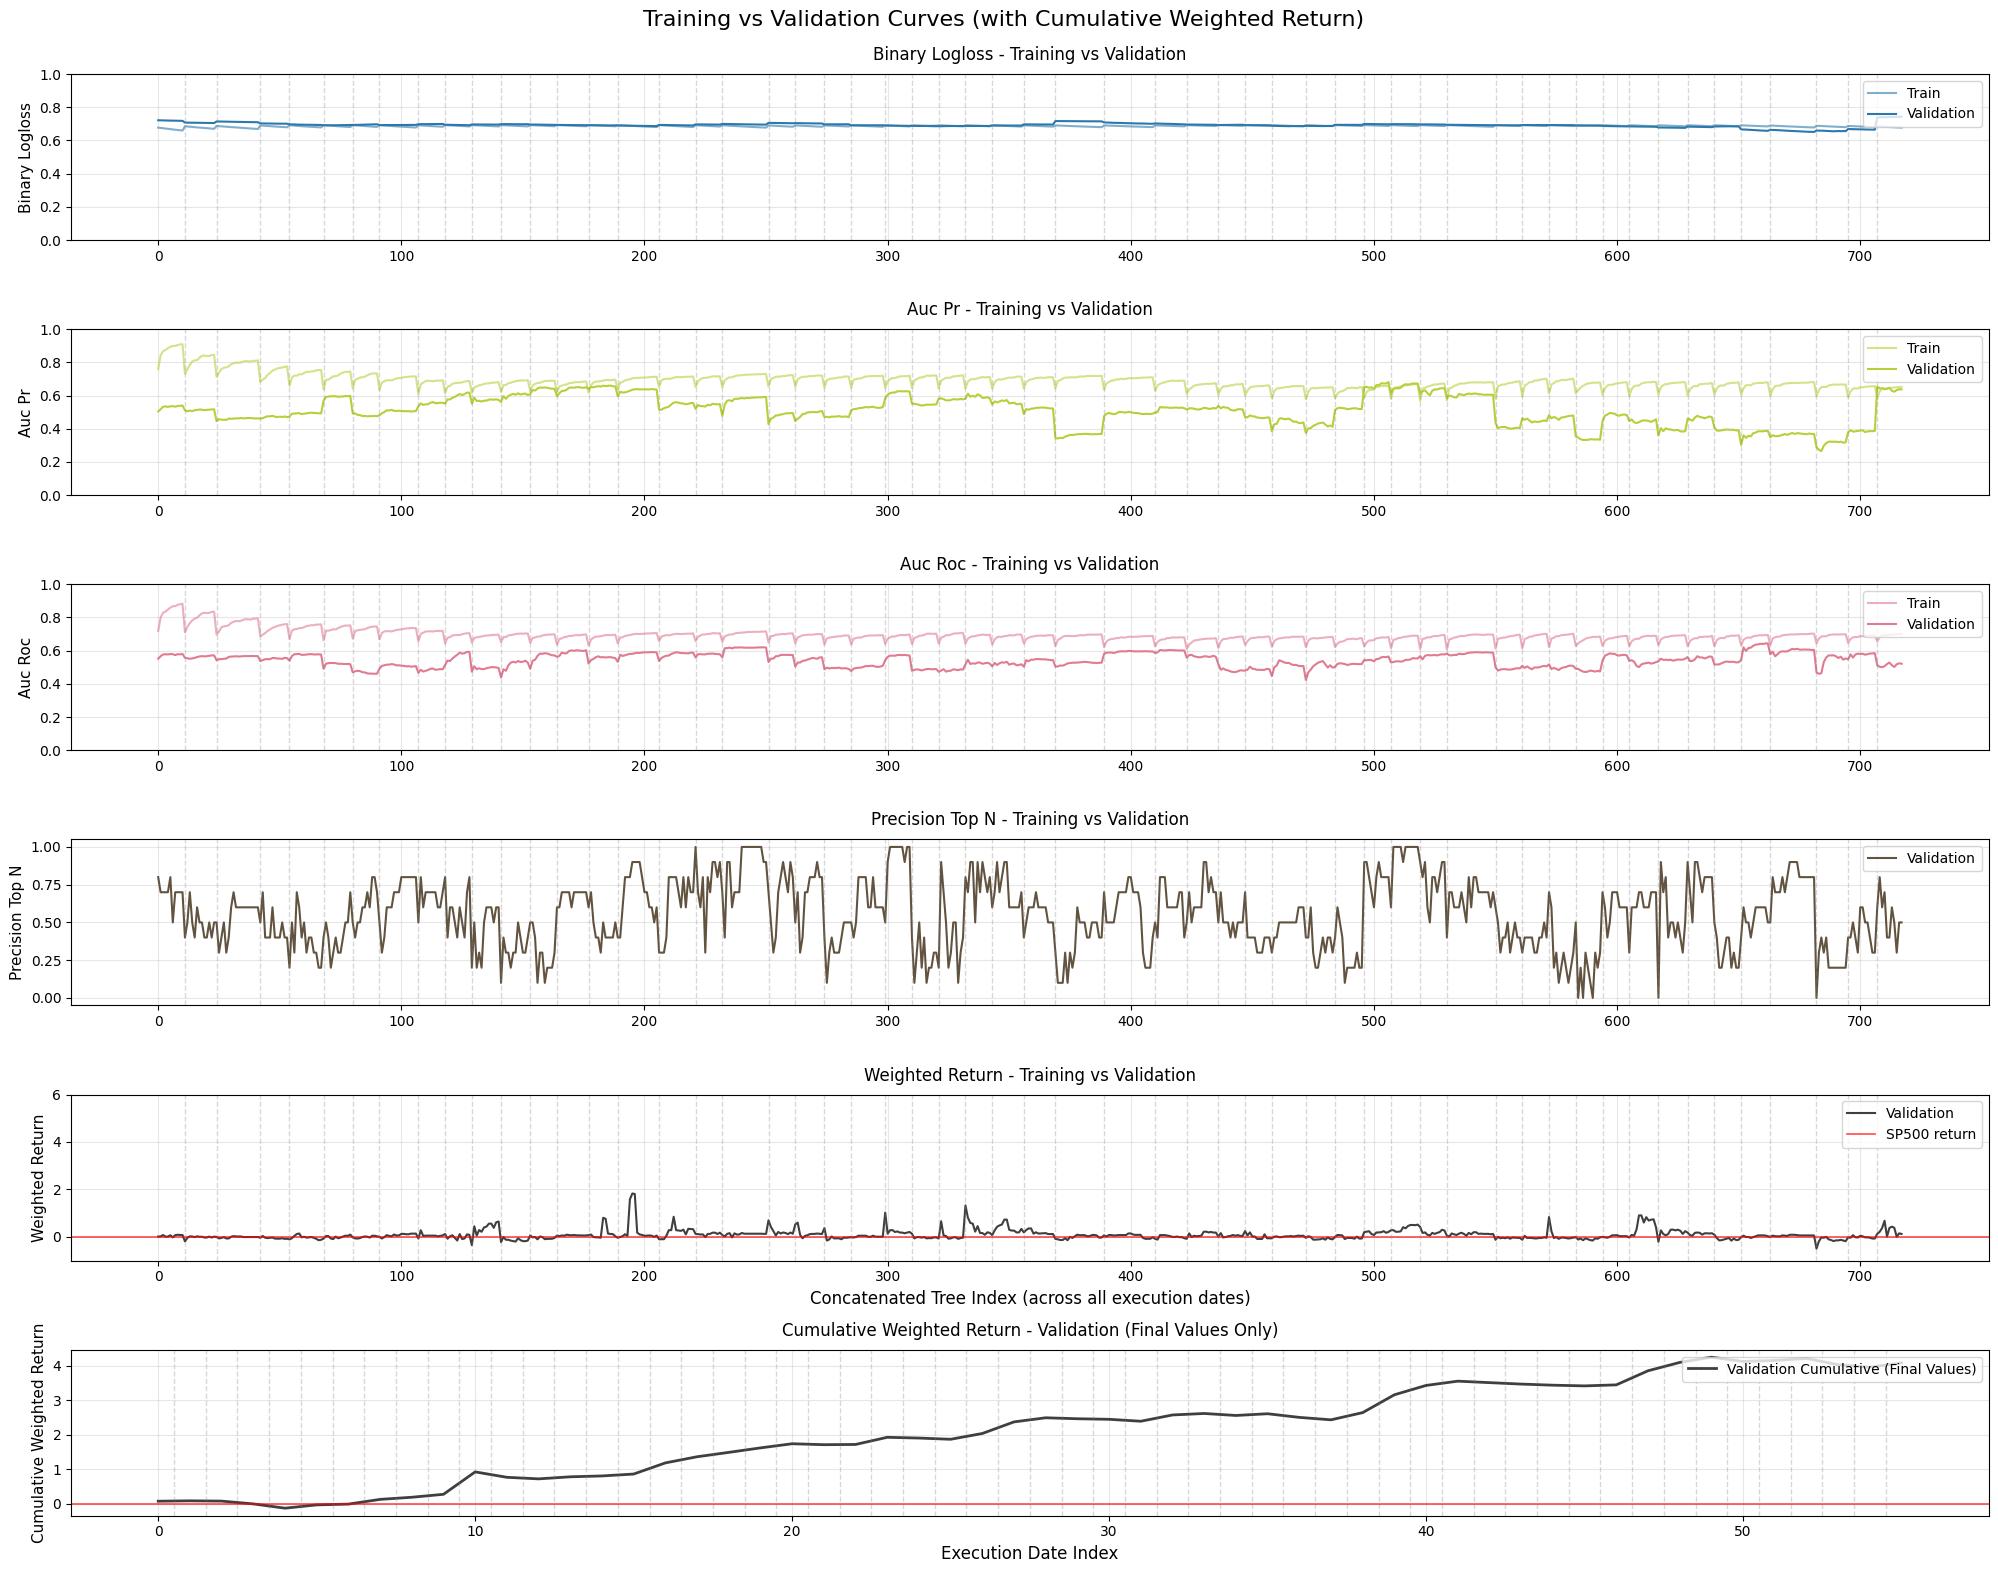

In [90]:
plot_concatenated_training_curves(
    all_results_pca,
    metrics=["binary_logloss", "auc-pr", "auc-roc", "precision-top-n", "weighted-return"],
)

## SHAP Values

All before feature important analysis was made in order to trees feature importance, but this isn't reliable. Let's make some SHAP Values analysis and see what's going on

In [93]:
shap.initjs()

Lets see the first model, with `sp500_change_730` feature, how was working. I will explore the model which has given this especific return

![Descripción de la imagen](../../assets/outlier_shap_values.jpg)

On this execution time, the model on validation set, has given a prediction to each ticker (prob to beat sp500), and we have choosen the TOP_N with most probabilities:

In [220]:
all_predicted_tickers[all_predicted_tickers['execution_date'] == '2014-09-30'].head(TOP_N)[['Ticker', 'diff_ch_sp500', 'prob']]

,Ticker,diff_ch_sp500,prob
86188,TYME,919.936572,0.723483
87413,FLO,0.404220,0.718484
85423,TGNA,0.019050,0.717404
87598,ZYXI,0.226496,0.717374
87206,INFY,0.312202,0.705376
84895,NVDA,0.382296,0.702942
86067,ABB,-0.150794,0.701524
86880,IPG,0.095547,0.695806
85047,HPQ,-0.209755,0.691792
86775,FLL,0.296062,0.690636


Lets see why the model has given a `prob=0.723483` to the **TYME** ticker

In [207]:
date = np.datetime64('2014-09-30T00:00:00.000000000')

model = all_models[date]

columns_trained = [col for col in data_set.columns if col not in get_columns_to_remove() and col != 'prob']
columns_trained.append('sp500_change_730')

date_df = all_predicted_tickers[all_predicted_tickers['execution_date'] == str(date)]
date_df = date_df[columns_trained].copy()

explainer = shap.Explainer(model)
shap_values = explainer.shap_values(date_df)

In [225]:
tyme_ticker_data = date_df.iloc[0, :]
tyme_ticker_shap_values = shap_values[0, :]
shap.force_plot(explainer.expected_value, tyme_ticker_shap_values, tyme_ticker_data)

So the `close_0 = 0.00923` value have given the most positive importance to the prediction. Lets see now for the TOP_N predictions:

In [226]:
top_n_tickers_data = date_df.iloc[:TOP_N, :]
top_n_tickers_shap_values = shap_values[:TOP_N, :]
shap.force_plot(explainer.expected_value, top_n_tickers_shap_values, top_n_tickers_data)

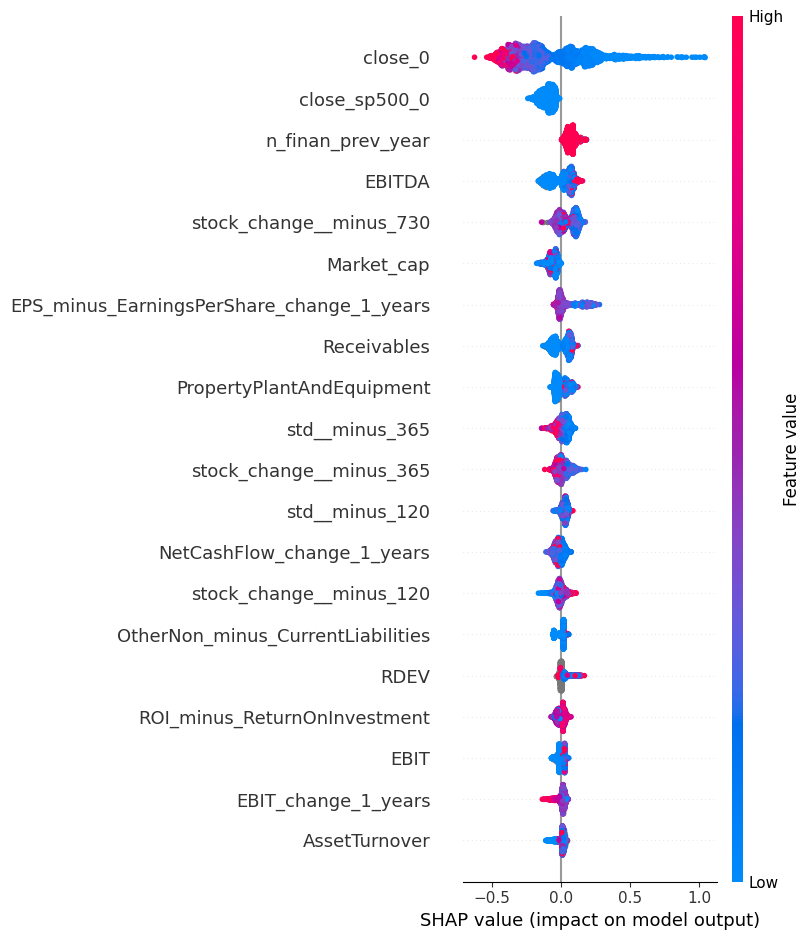

In [227]:
shap.summary_plot(shap_values, date_df)

We can observe that high values in `close_0` consistently contribute a significant negative importance to the model's prediction, while low values tend to provide a strong positive importance. This implies that the model tends to assign a higher probability of outperforming the SP500 to tickers with low prices at the execution moment.

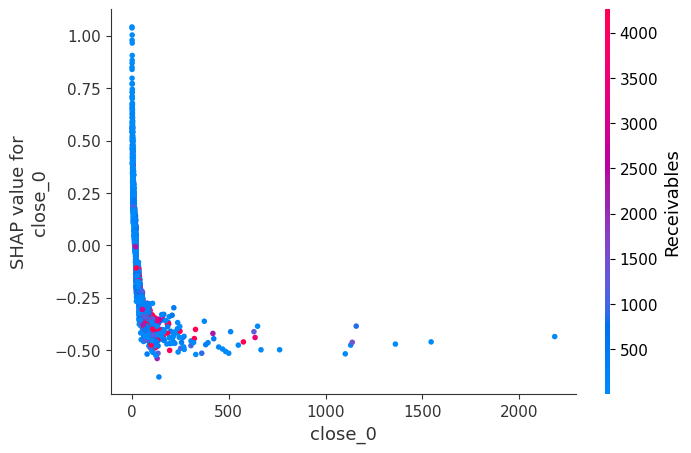

In [259]:
shap.dependence_plot('close_0', shap_values, date_df)

This analysis was for the given models, now lets see against my models (with some pca components and lower overfitting)

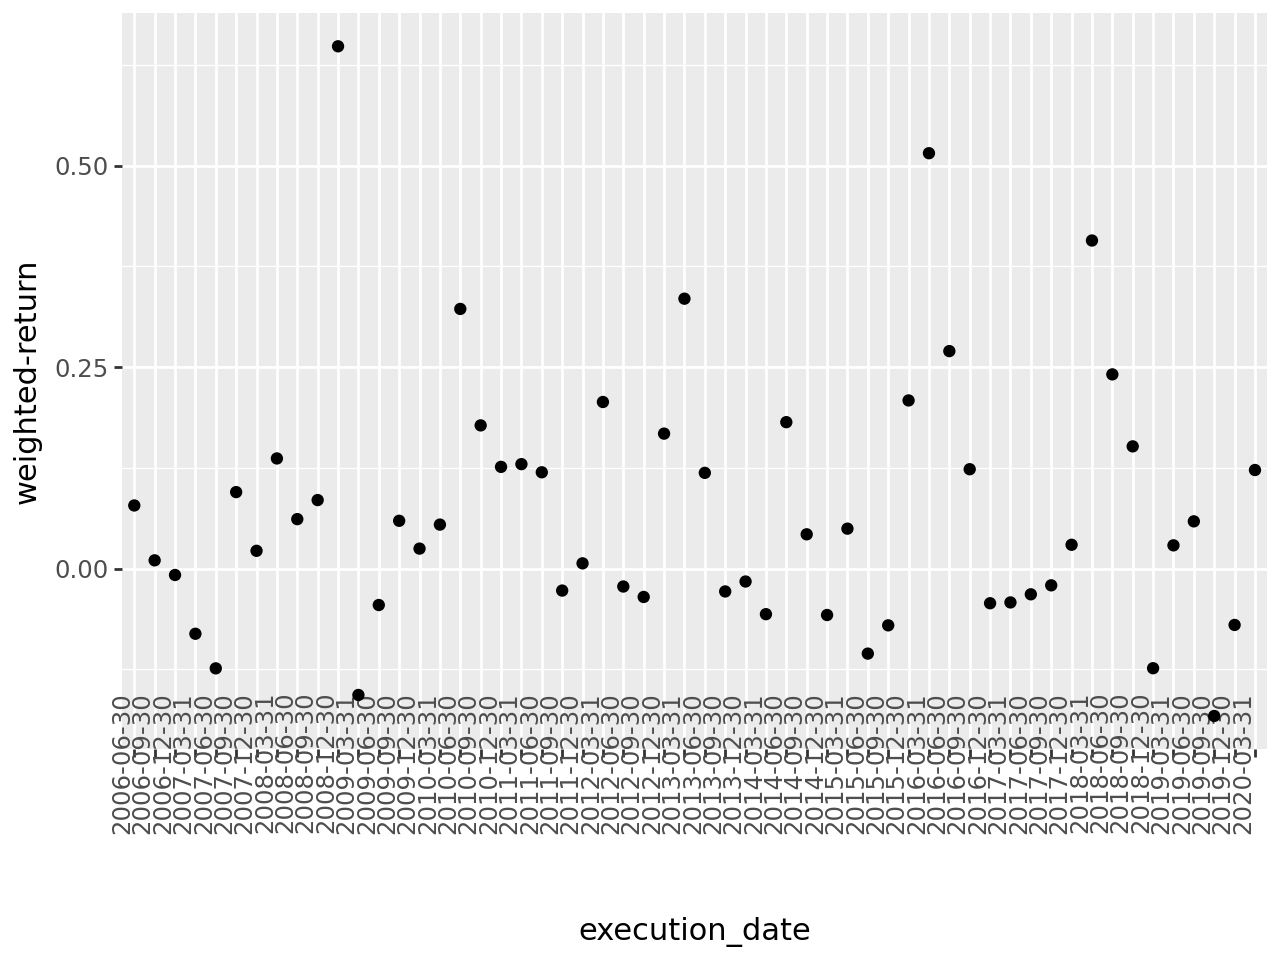

In [268]:
ggplot(pca_test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

Lets take a look for example to `2016-06-30` date model

In [276]:
date = np.datetime64('2016-06-30T00:00:00.000000000')
all_predicted_tickers_pca[all_predicted_tickers_pca['execution_date'] == str(date)].head(TOP_N)[['Ticker', 'diff_ch_sp500', 'prob']]

,Ticker,diff_ch_sp500,prob
106275,AZN,0.020921,0.487594
104762,ADI,0.249674,0.486905
107594,CNHI,0.431506,0.486905
105055,INCY,0.419635,0.486905
104817,NVDA,1.931837,0.486905
105980,MXIM,0.140407,0.486905
105480,BAX,0.196317,0.486905
104829,MDT,-0.111992,0.486905
104720,WDAY,0.144415,0.486905
106732,WDC,0.762421,0.486905


Let's take a look to NVDA prediction. 

In [277]:
last_pca_model = all_models_pca[date]

date_df = all_predicted_tickers_pca[all_predicted_tickers_pca['execution_date'] == str(date)]
date_df = add_pcs(date_df, pca_pipelines, fit=False).drop(columns=get_columns_to_remove() + ['prob'], errors="ignore")

pca_explainer = shap.Explainer(last_pca_model)
pca_shap_values = pca_explainer.shap_values(date_df)

In [282]:
nvda_ticker_data = date_df.iloc[4, :]
nvda_ticker_shap_values = pca_shap_values[4, :]
shap.force_plot(pca_explainer.expected_value, nvda_ticker_shap_values, nvda_ticker_data)

`ResearchAndDevelopmenteExpenses` has taken a lot of importance in this prediction. Now, lets see the top_n predictions:

In [283]:
pca_top_n_ticker_data = date_df.iloc[:TOP_N, :]
pca_top_n_ticker_shap_values = pca_shap_values[:TOP_N, :]
shap.force_plot(pca_explainer.expected_value, pca_top_n_ticker_shap_values, pca_top_n_ticker_data)

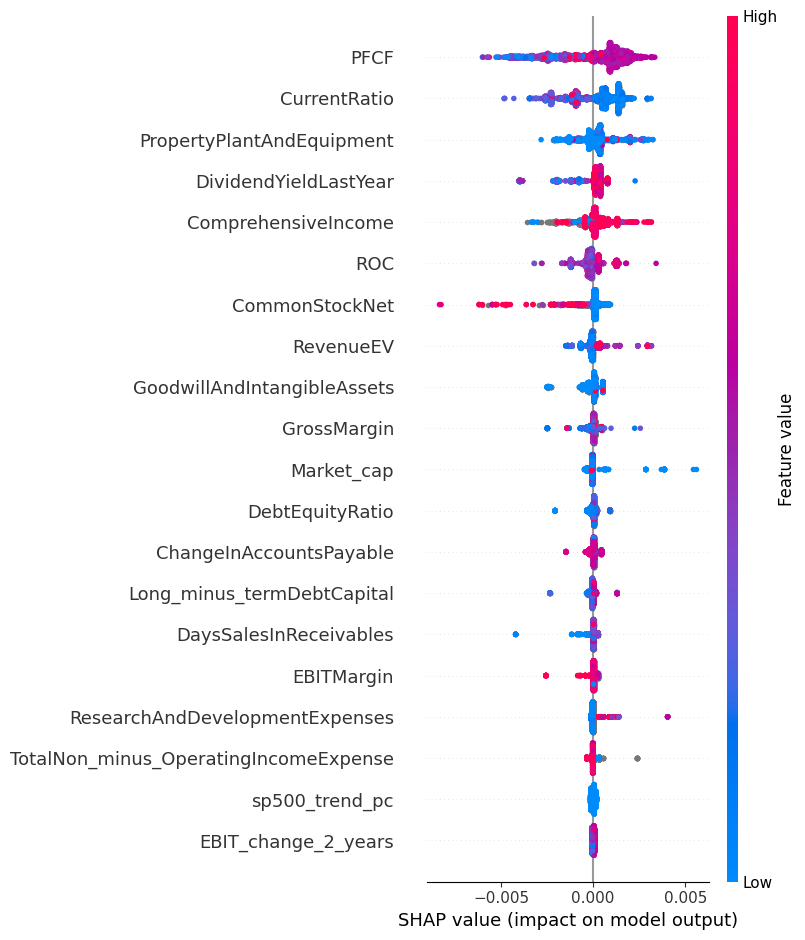

In [285]:
shap.summary_plot(
    pca_shap_values,
    date_df
)

For this especific execution_date model, the 'close_0' feature has disapeared. Lets see for example another date, a date with a very bad `weighted-return`:

In [286]:
date = np.datetime64('2019-09-30T00:00:00.000000000')
all_predicted_tickers_pca[all_predicted_tickers_pca['execution_date'] == str(date)].head(TOP_N)[['Ticker', 'diff_ch_sp500', 'prob']]

,Ticker,diff_ch_sp500,prob
146733,QGEN,0.463957,0.461136
149133,MRK,-0.118613,0.461136
146035,MDT,-0.154485,0.461136
148968,NICE,0.450974,0.461136
148335,MMC,0.037707,0.461041
149297,WM,-0.115666,0.461041
148273,VRSK,0.052118,0.461041
146097,PAYX,-0.134045,0.461041
146968,EVRG,-0.336710,0.461041
148895,BATRA,-0.390007,0.461041


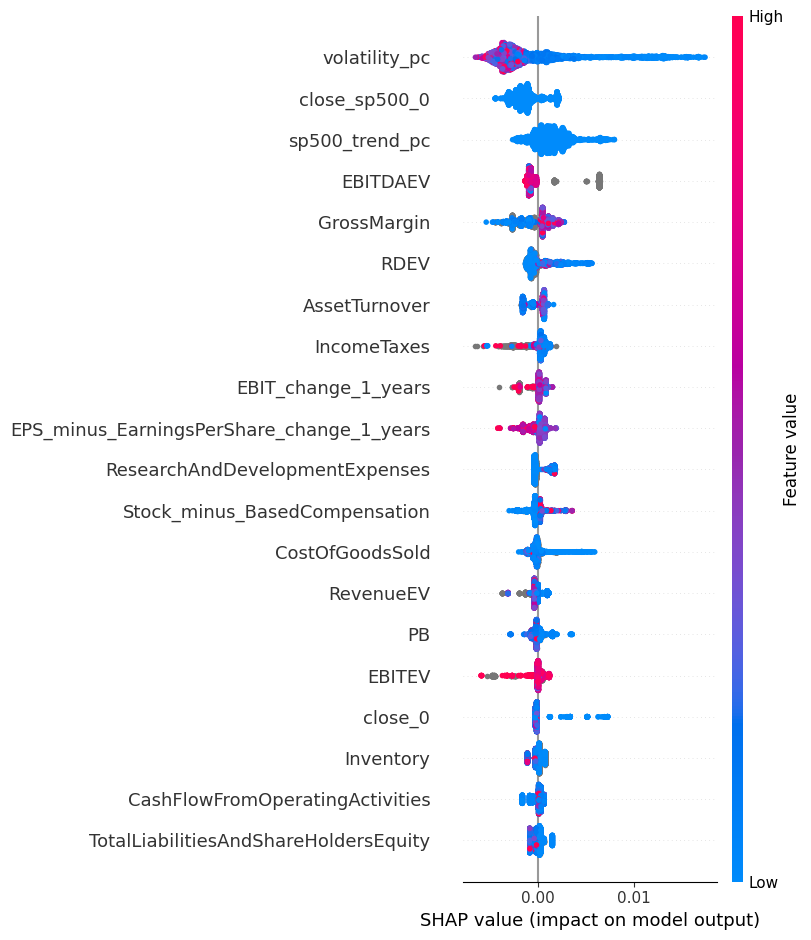

In [294]:
pca_bad_model = all_models_pca[date]

date_df = all_predicted_tickers_pca[all_predicted_tickers_pca['execution_date'] == str(date)]
date_df = add_pcs(date_df, pca_pipelines, fit=False).drop(columns=get_columns_to_remove() + ['prob'], errors="ignore")

pca_explainer = shap.Explainer(pca_bad_model)
pca_shap_values = pca_explainer.shap_values(date_df)

shap.summary_plot(
    pca_shap_values,
    date_df
)

---

In [50]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt